In [28]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

19.97978556 0.86842983 5.32268922 50.98631704 0.08262078 2.44610191 -49.92376088


/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_7367/3332746724.py:10: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-1 * R*b + c)+ d * np.exp(-1 * H*e + f) + j
/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_7367/3332746724.py:10: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-1 * R*b + c)+ d * np.exp(-1 * H*e + f) + j


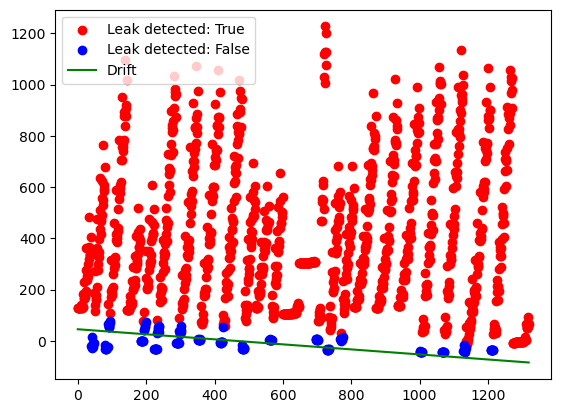

In [42]:

df = pd.read_csv("/Users/benfunk/DataspellProjects/MethaneDataScience/Output/With low Data .csv")
xDataResistance = df.loc[:, 'Resistance']
xDataRatio = df.loc[:, 'Ratio']
xDataRH = df.loc[:, 'RelativeHumidity']
xDataTemp = df.loc[:, 'Temperature']
yDataTargetPPM = df.loc[:, 'Target PPM']

def funct3(X, a, b, c, d, e, f, j):
    R, H, T = X
    return a * np.exp(-1 * R*b + c)+ d * np.exp(-1 * H*e + f) + j

p0 = 1, 1, .5, 1, 1, 1, 1
popt, pcov = sc.optimize.curve_fit(funct3, (xDataResistance, xDataRH, xDataTemp), yDataTargetPPM, p0, maxfev=1000000)

popt=[ 19.97978556,   0.86842983 ,  5.32268922,  50.98631704 ,  0.08262078,
       2.44610191, -49.92376088]
print(*popt)
# Create 'predicted' column
df['predicted'] = funct3((xDataResistance, xDataRH, xDataTemp), *popt)

# Create a new DataFrame where 'Target PPM' is 0
# Create a new DataFrame where 'Target PPM' is 0
df2 = df[df['Target PPM'] == 0]

# Fit a line to the predicted data using only the subset of data where 'Target PPM' is 0
slope, intercept = np.polyfit(np.arange(len(df2)), df2['predicted'], 1)

# Calculate the drift for the entire DataFrame
df['drift'] = np.arange(len(df))*slope + intercept

# Correct for drift
df['corrected'] = df['predicted'] - df['drift']

# Detect methane leaks
df['residual'] = df['corrected'] - df['predicted']

df['leak_detected'] = (df['predicted'] > df['drift']+50)

# Plotting
time_indices = np.arange(len(df))
for leak_detected, color in zip([True, False], ['red', 'blue']):
    plt.scatter(time_indices[df['leak_detected'] == leak_detected],
                df['predicted'][df['leak_detected'] == leak_detected],
                color=color,
                label=f"Leak detected: {leak_detected}")

# Plot the drift
plt.plot(time_indices, df['drift'], color='green', label='Drift')

plt.legend()
plt.show()